## Lifestyle analysis

#### How step count affects change in pain_level - part 2

Compare the change in pain_level before and after a step count recording

In [2]:
# importing necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import math
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel
from statsmodels.formula.api import mixedlm
import statsmodels.formula.api as smf
from scipy import stats
from scipy.stats import poisson
from scipy.stats import shapiro, kstest, normaltest, anderson

In [3]:
# Read in filtered data
file_path = 'data/filtered_data.csv'
fdf = pd.read_csv(file_path)
fdf.shape

(26141, 47)

In [4]:
# Users that never record having a period
all_users = fdf['userID'].unique()

# userID where some rows with period is 1
step_users = fdf[fdf['steps'].notnull()]['userID'].unique()

# Other userIDs
no_step_users = set(all_users) - set(step_users)

print("User count:", len(all_users))
print("Users that record steps at least once:", len(step_users))
print("Users that never record steps:", len(no_step_users))

print("Mean steps", round(fdf['steps'].mean(), 1))
print("Median steps", fdf['steps'].median())

User count: 1918
Users that record steps at least once: 392
Users that never record steps: 1526
Mean steps 6720.3
Median steps 6212.0


Lifestyle effects variables of interest:
'date', 'userID', 'period', 'pain_level', 'sleep', 'sleep_minutes', 'steps'

In [6]:
# Sort data by userID and date
steps_df = fdf[['ID', 'date', 'userID', 'period', 'pain_level', 'steps']]
steps_df = steps_df.sort_values(by=['userID', 'date'])

steps_df['period'] = steps_df['period'].astype(int)
steps_df['pain_level'] = steps_df['pain_level'].astype(float)
steps_df['date'] = pd.to_datetime(steps_df['date'])

print(len(steps_df))
steps_df.head()

26141


,ID,date,userID,period,pain_level,steps
6,248,2021-05-03,92,0,NaN,15557.0
8,257,2021-05-04,92,0,NaN,6000.0
14,264,2021-05-05,92,0,NaN,2900.0
16,266,2021-05-06,92,0,NaN,5700.0
18,269,2021-05-07,92,0,NaN,14200.0


# Difference in pain before and after steps

In [8]:
steps_df.head()

,ID,date,userID,period,pain_level,steps
6,248,2021-05-03,92,0,NaN,15557.0
8,257,2021-05-04,92,0,NaN,6000.0
14,264,2021-05-05,92,0,NaN,2900.0
16,266,2021-05-06,92,0,NaN,5700.0
18,269,2021-05-07,92,0,NaN,14200.0


In [9]:
#user113 = steps_df.loc[(steps_df['userID'] == 113)]
#user113

#steps_df.loc[(steps_df['userID'] == 113) & (steps_df['pain_level'].notnull())]

In [10]:

def get_step_users(df):
    # Create a list of all users that have entries for step count and pain
    users = 0
    count = 0
    step_users = []
    
    # Iterate over each user_ID to create a list of all user_IDs that have steps counts and pain_level entries
    for user_id in df['userID'].unique():
    
        # Filter the DataFrame for the current user_ID
        user_df = df[df['userID'] == user_id]
       
        user_entries = len(user_df)
        step_entries = len(user_df[(user_df['steps'].notnull())])
        pain_entries = len(user_df[(user_df['pain_level'].notnull())])
        users += 1
        
        if (step_entries >0) & (pain_entries >0):
            step_users.append(user_id)
            count += 1
    return step_users
    
def agg_user_data(df, userID):
    # Get all rows related to this user from the df
    user = df[(df['userID'] == userID)]

    # Aggregate rows with the same date
    user_agg = user.groupby('date').agg({
        'ID': 'first', # keep one ID
        'userID': 'first',  # userID is the same 
        'period': 'max',  # 1 if any entry is 1
        'pain_level': 'max',  # max pain_level column 
        'steps': 'max'  #  max steps value
    }).reset_index()
    return user_agg

def get_pain_prior(df, step_date):
    
    # For step entries, get the pain level for up to 2 days prior and average
    start_date = pd.to_datetime(step_date) - timedelta(days=3)
    end_date = pd.to_datetime(step_date) - timedelta(days=1)
    
    # Filter data from df for timeframe
    pain_levels = df.loc[(df['date'] >= start_date) & (df['date'] <= end_date)]
    levels = pain_levels['pain_level'].dropna()  # Remove NaNs
    levels_clean = levels[levels != 0]  # Remove zeros

    if levels_clean.empty:
        return
        
    # Calculate the mean steps
    mean_pain = levels_clean.mean()
    if not math.isnan(mean_pain):
        mean_pain = round(mean_pain, 0)
    
    return mean_pain
    
def get_pain_after(df, step_date):    
    
    # For step entries, get the pain level for up to 2 days after and average
    start_date = pd.to_datetime(step_date) + timedelta(days=1)
    end_date = pd.to_datetime(step_date) + timedelta(days=3)
    
    # Filter data from df for timeframe
    pain_levels = df.loc[(df['date'] >= start_date) & (df['date'] <= end_date)]    
    levels = pain_levels['pain_level'].dropna()  # Remove NaNs
    levels_clean = levels[levels != 0]  # Remove zeros
          
    if levels_clean.empty:
        return
        
    # Calculate the mean steps
    mean_pain = levels_clean.mean()
    if not math.isnan(mean_pain):
        mean_pain = round(mean_pain, 0)
    
    return mean_pain


query_date = '2023-09-08'
user113 = steps_df.loc[(steps_df['userID'] == 113)]
pain_level = get_pain_after(user113, query_date)
print(pain_level)

test_df = steps_df.loc[steps_df['userID'] == 113]
get_pain_after(test_df, query_date)

In [12]:
def get_pain_change_rows(df, indices):
    
    # Create a new df to store the steps, pain_level_prior rows
    user_pain_change_df = pd.DataFrame(columns=['ID', 'userID', 'pain_prior', 'pain_now', 'pain_after', 'steps', 'period'])
    
    for i in indices:
        # Get date of pain_level for record with ID i
        step_date = df[df['ID'] == i]['date']
        step_date = step_date.tolist()[0]
    
        steps = df[df['ID'] == i]['steps']
        steps = steps.tolist()[0]

        # pain on same day
        pain_now = df[df['ID'] == i]['pain_level']
        pain_now = pain_now.tolist()[0]

        # Get the pain_level prior to this date
        pain_prior = get_pain_prior(df, step_date)
        
        # Get the pain_level day after to this date
        pain_after = get_pain_after(df, step_date)

        period = df[df['ID'] == i]['period']
        period = period.tolist()[0]

        userID = df[df['ID'] == i]['userID']
        userID = userID.tolist()[0]

        # Add a new row to steps_pain_df for every entry found
        new_row = pd.DataFrame([[i, userID, pain_prior, pain_now, pain_after, steps, period]], columns=['ID', 'userID', 'pain_prior', 'pain_now', 'pain_after', 'steps', 'period'])
        new_row_clean = new_row.dropna(axis=0).dropna(axis=1, how='all')
        #print("empty", new_row_clean.empty)
        
        # Concatenate only if new_row_clean is not empty
        if not new_row_clean.empty:
            user_pain_change_df = pd.concat([user_pain_change_df, new_row_clean], ignore_index=True)
    return user_pain_change_df
    
def extract_pain_change(df):
    # Create a larger df to add the new rows for each user
    all_pain_change_df = pd.DataFrame(columns=['ID', 'userID', 'pain_prior', 'pain_now', 'pain_after', 'steps', 'period'])

    # Extract the users with step and pain_level counts from the df
    step_users = get_step_users(df)
    
    # Iterate over all the users in stepping_users
    for user in step_users:
        # Get the user entries from df and aggregate it 
        user_agg = agg_user_data(df, user)

        # Filter all entries from aggregated data where a pain_level is not null
        pain_entries = user_agg[(user_agg['pain_level'].notnull())]
        
        # Get the data ID for pain entries
        indices = pain_entries.reset_index()['ID']

        user_pain_change_df = get_pain_change_rows(user_agg, indices)
        user_pain_change_df_clean = user_pain_change_df.dropna(axis=0).dropna(axis=1, how='all')

        # Concatenate only if user_steps_pain_clean has at least one non-NaN entry
        if not user_pain_change_df_clean.empty:
            all_pain_change_df = pd.concat([all_pain_change_df, user_pain_change_df_clean], ignore_index=True)
        
    return all_pain_change_df


In [ ]:
all_delta_df = extract_pain_change(steps_df)

In [14]:
all_delta_df

,ID,userID,pain_prior,pain_now,pain_after,steps,period
0,8270,113,2.0,2.0,5.0,19000.0,1
1,8269,113,2.0,2.0,6.0,10000.0,1
2,8368,113,2.0,8.0,4.0,15000.0,1
3,10941,113,4.0,2.0,2.0,11000.0,1
4,13092,113,4.0,5.0,4.0,10000.0,0
...,...,...,...,...,...,...,...
522,29968,7686,8.0,8.0,8.0,4256.0,0
523,29994,7686,8.0,8.0,8.0,4950.0,0
524,30539,7946,7.0,6.0,6.0,12000.0,0
525,31330,8258,4.0,6.0,4.0,8000.0,0


In [15]:
# Drop NaNs
delta_df = all_delta_df.dropna() 
print(len(delta_df))
delta_df

527


,ID,userID,pain_prior,pain_now,pain_after,steps,period
0,8270,113,2.0,2.0,5.0,19000.0,1
1,8269,113,2.0,2.0,6.0,10000.0,1
2,8368,113,2.0,8.0,4.0,15000.0,1
3,10941,113,4.0,2.0,2.0,11000.0,1
4,13092,113,4.0,5.0,4.0,10000.0,0
...,...,...,...,...,...,...,...
522,29968,7686,8.0,8.0,8.0,4256.0,0
523,29994,7686,8.0,8.0,8.0,4950.0,0
524,30539,7946,7.0,6.0,6.0,12000.0,0
525,31330,8258,4.0,6.0,4.0,8000.0,0


In [16]:
# Create delta variables
delta_df.loc[:, 'delta_pain_21'] = delta_df['pain_now'] - delta_df['pain_prior']
delta_df.loc[:, 'delta_pain_32'] = delta_df['pain_after'] - delta_df['pain_now']
delta_df.loc[:, 'delta_pain_31'] = delta_df['pain_after'] - delta_df['pain_prior']
# negative delta indicates a reduction in pain
# positive delta indicates an increase in pain

delta_df

,ID,userID,pain_prior,pain_now,pain_after,steps,period,delta_pain_21,delta_pain_32,delta_pain_31
0,8270,113,2.0,2.0,5.0,19000.0,1,0.0,3.0,3.0
1,8269,113,2.0,2.0,6.0,10000.0,1,0.0,4.0,4.0
2,8368,113,2.0,8.0,4.0,15000.0,1,6.0,-4.0,2.0
3,10941,113,4.0,2.0,2.0,11000.0,1,-2.0,0.0,-2.0
4,13092,113,4.0,5.0,4.0,10000.0,0,1.0,-1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
522,29968,7686,8.0,8.0,8.0,4256.0,0,0.0,0.0,0.0
523,29994,7686,8.0,8.0,8.0,4950.0,0,0.0,0.0,0.0
524,30539,7946,7.0,6.0,6.0,12000.0,0,-1.0,0.0,-1.0
525,31330,8258,4.0,6.0,4.0,8000.0,0,2.0,-2.0,0.0


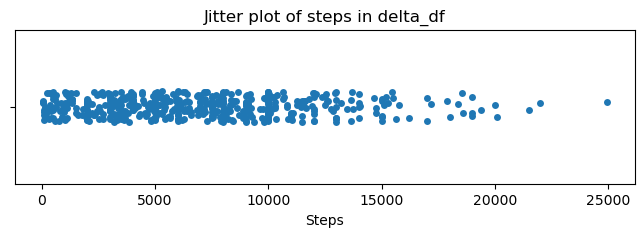

In [17]:
plt.figure(figsize=(8, 2))
sns.stripplot(x='steps', data=delta_df)
plt.title('Jitter plot of steps in delta_df')
plt.xlabel('Steps')
plt.show()

- 100,000 steps ~ 76.2 kilometers
- 50,000 steps ~ 38 kilometers
- 30,000 steps ~ 23 kilometers

In [19]:
print(len(all_delta_df), len(delta_df))

527 527


In [20]:
# Save copy of filtered df to file - rows where userIDs are removed
delta_df.to_csv('data/delta_df.csv', index=False)

In [21]:
# Aggregate data to get the number of entries per user
delta_entry_cnt = delta_df['userID'].value_counts()
delta_entry_cnt = delta_entry_cnt.reset_index()
delta_entry_cnt = delta_entry_cnt.sort_values(by='count', ascending=False)
delta_entry_cnt.head(10)

,userID,count
0,3038,36
1,113,35
2,4049,27
3,5688,21
4,2077,20
5,6153,18
6,6175,17
7,928,16
8,7486,16
9,4974,15


In [22]:
# Number of users
print("Number of users:", len(delta_df['userID'].unique()))
print("Number of entries:", len(delta_df))

Number of users: 115
Number of entries: 527


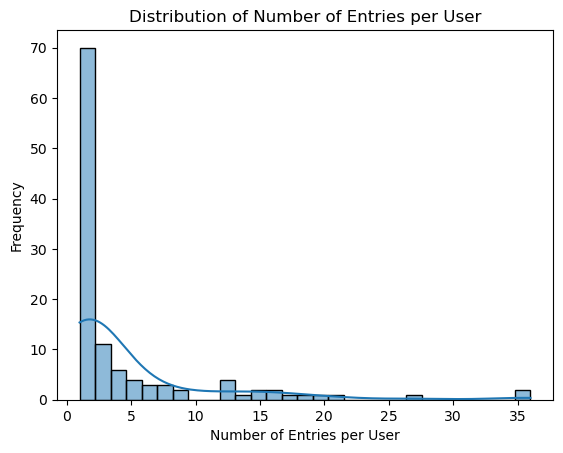

In [23]:
# Visualize the distribution
sns.histplot(delta_entry_cnt['count'], kde=True)
plt.xlabel('Number of Entries per User')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Entries per User')
plt.show()

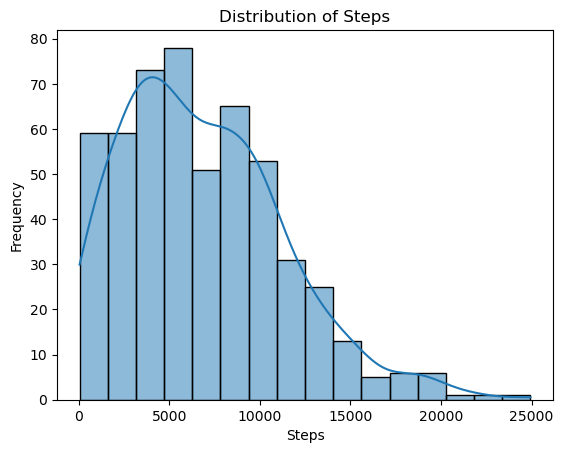

Skewness: 0.7612981779826588
Kurtosis: 0.4999180843636446
Shapiro-Wilk Statistic: 0.9561773977338104, p-value: 2.0912658425560148e-11


In [24]:
# Distribution plot for 'steps'
sns.histplot(delta_df['steps'], kde=True)
plt.title('Distribution of Steps')
plt.xlabel('Steps')
plt.ylabel('Frequency')
plt.show()

# Calculate skewness and kurtosis
skewness = stats.skew(delta_df['steps'])
print(f"Skewness: {skewness}")
kurtosis = stats.kurtosis(delta_df['steps'])
print(f"Kurtosis: {kurtosis}")

# Shapiro-Wilk test
stat, p_value = shapiro(delta_df['steps'])
print(f"Shapiro-Wilk Statistic: {stat}, p-value: {p_value}")

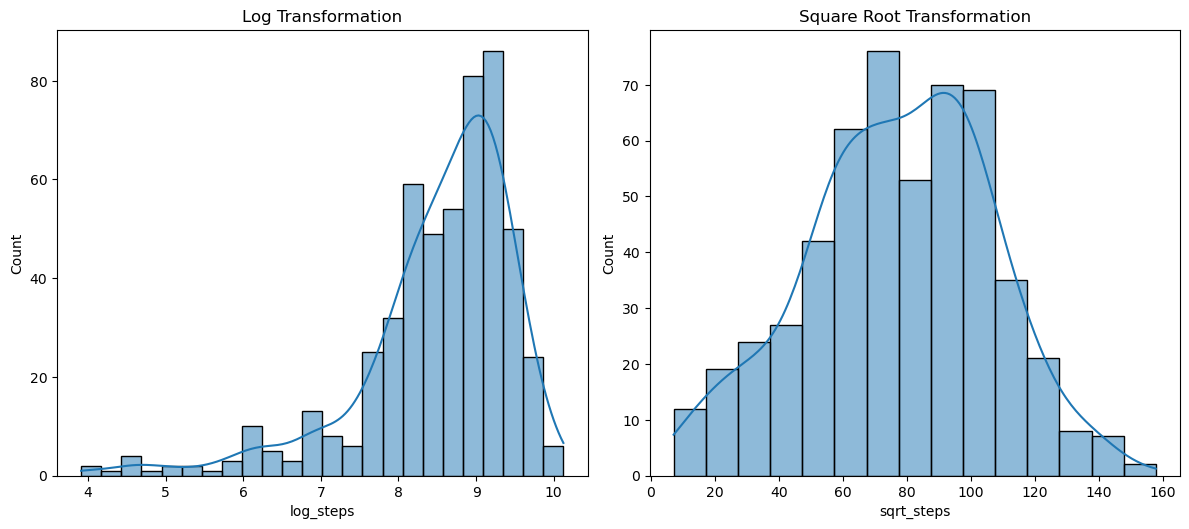

Shapiro-Wilk Test for Normality
Original: ShapiroResult(statistic=0.9561773977338104, pvalue=2.0912658425560148e-11)
Log Transformation: ShapiroResult(statistic=0.8603689844981042, pvalue=3.0073218545858747e-21)
Square Root Transformation: ShapiroResult(statistic=0.9918564577776526, pvalue=0.005504340889247776)


In [25]:
# Transformation
delta_df.loc[:, 'log_steps'] = np.log(delta_df['steps'])  # Log 
delta_df.loc[:, 'sqrt_steps'] = np.sqrt(delta_df['steps'])  # Square Root 

# Plot Histograms
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
sns.histplot(delta_df['log_steps'], kde=True)
plt.title('Log Transformation')
plt.subplot(2, 2, 2)
sns.histplot(delta_df['sqrt_steps'], kde=True)
plt.title('Square Root Transformation')
plt.tight_layout()
plt.show()

# Shapiro-Wilk Test for Normality
print("Shapiro-Wilk Test for Normality")
print("Original:", shapiro(delta_df['steps']))
print("Log Transformation:", shapiro(delta_df['log_steps']))
print("Square Root Transformation:", shapiro(delta_df['sqrt_steps']))

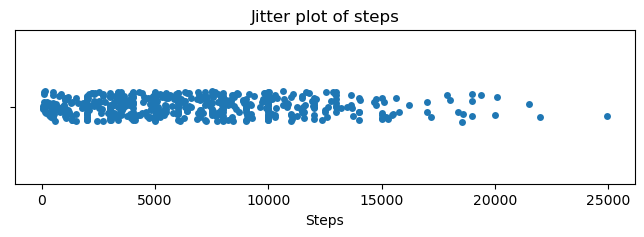

In [26]:
plt.figure(figsize=(8, 2))
sns.stripplot(x='steps', data=delta_df)
plt.title('Jitter plot of steps')
plt.xlabel('Steps')
plt.show()

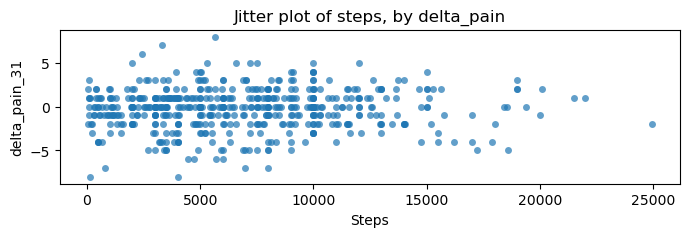

In [27]:
plt.figure(figsize=(8, 2))
sns.stripplot(x='steps', y='delta_pain_31', data=delta_df, jitter=0.5, alpha=0.7, native_scale=True)
plt.title('Jitter plot of steps, by delta_pain')
plt.xlabel('Steps')
plt.show()

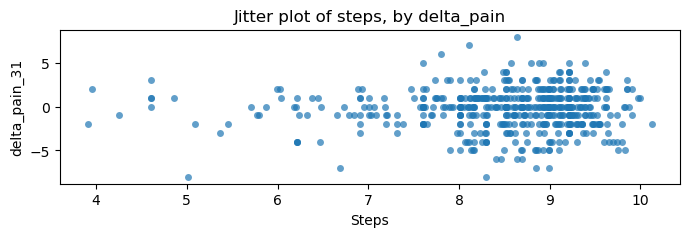

In [28]:
plt.figure(figsize=(8, 2))
sns.stripplot(x='log_steps', y='delta_pain_31', data=delta_df, jitter=0.5, alpha=0.7, native_scale=True)
plt.title('Jitter plot of steps, by delta_pain')
plt.xlabel('Steps')
plt.show()

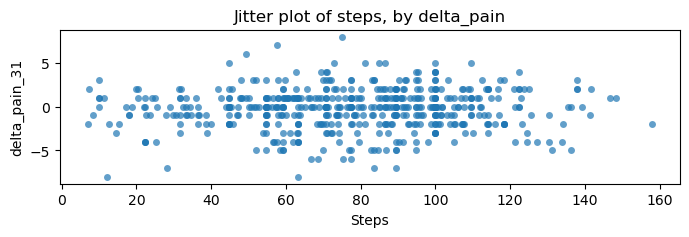

In [29]:
plt.figure(figsize=(8, 2))
sns.stripplot(x='sqrt_steps', y='delta_pain_31', data=delta_df, jitter=0.5, alpha=0.7, native_scale=True)
plt.title('Jitter plot of steps, by delta_pain')
plt.xlabel('Steps')
plt.show()

In [30]:
# Mixed Linear model
linear_delta_model1 = smf.mixedlm("delta_pain_31 ~ steps", delta_df, groups=delta_df["userID"])
linear_delta_result1 = linear_delta_model1.fit()

# Results
print(linear_delta_result1.summary())
print(f"Coefficient for steps: {linear_delta_result1.params['steps']:.10f}")
print(f"Standard error: {linear_delta_result1.bse['steps']:.10f}")

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: delta_pain_31
No. Observations: 527     Method:             REML         
No. Groups:       115     Scale:              3.8164       
Min. group size:  1       Log-Likelihood:     -1172.4969   
Max. group size:  36      Converged:          Yes          
Mean group size:  4.6                                      
------------------------------------------------------------
             Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept    -0.302     0.258  -1.172  0.241  -0.808   0.203
steps        -0.000     0.000  -1.436  0.151  -0.000   0.000
Group Var     2.584     0.363                               

Coefficient for steps: -0.0000370870
Standard error: 0.0000258310


In [31]:
# Mixed Linear model
linear_delta_model2 = smf.mixedlm("delta_pain_31 ~ steps + period", delta_df, groups=delta_df["userID"])
linear_delta_result2 = linear_delta_model2.fit()

# Results
print(linear_delta_result2.summary())
print(f"Coefficient for steps: {linear_delta_result2.params['steps']:.10f}")
print(f"Standard error: {linear_delta_result2.bse['steps']:.10f}")

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: delta_pain_31
No. Observations: 527     Method:             REML         
No. Groups:       115     Scale:              3.8230       
Min. group size:  1       Log-Likelihood:     -1169.7837   
Max. group size:  36      Converged:          Yes          
Mean group size:  4.6                                      
------------------------------------------------------------
             Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept    -0.092     0.266  -0.344  0.731  -0.613   0.430
period[T.1]  -0.618     0.243  -2.543  0.011  -1.094  -0.142
steps        -0.000     0.000  -1.550  0.121  -0.000   0.000
Group Var     2.353     0.347                               

Coefficient for steps: -0.0000397154
Standard error: 0.0000256199


In [32]:
# Log Transformation
log_delta_model1 = smf.mixedlm("delta_pain_31 ~ log_steps", delta_df, groups=delta_df["userID"])
log_delta_results1 = log_delta_model1.fit()

# Results
print(log_delta_results1.summary())
print(f"Coefficient for log_steps: {log_delta_results1.params['log_steps']:.10f}")
print(f"Standard error: {log_delta_results1.bse['log_steps']:.10f}")

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: delta_pain_31
No. Observations: 527     Method:             REML         
No. Groups:       115     Scale:              3.8440       
Min. group size:  1       Log-Likelihood:     -1164.8126   
Max. group size:  36      Converged:          Yes          
Mean group size:  4.6                                      
------------------------------------------------------------
             Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept     0.199     1.031   0.193  0.847  -1.822   2.220
log_steps    -0.088     0.120  -0.735  0.462  -0.324   0.147
Group Var     2.516     0.358                               

Coefficient for log_steps: -0.0884168345
Standard error: 0.1202784054


In [33]:
# Log Transformation
log_delta_model2 = smf.mixedlm("delta_pain_31 ~ log_steps + period", delta_df, groups=delta_df["userID"])
log_delta_results2 = log_delta_model2.fit()

# Results
print(log_delta_results2.summary())
print(f"Coefficient for log_steps: {log_delta_results2.params['log_steps']:.10f}")
print(f"Standard error: {log_delta_results2.bse['log_steps']:.10f}")

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: delta_pain_31
No. Observations: 527     Method:             REML         
No. Groups:       115     Scale:              3.8457       
Min. group size:  1       Log-Likelihood:     -1162.0119   
Max. group size:  36      Converged:          Yes          
Mean group size:  4.6                                      
------------------------------------------------------------
             Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept     0.682     1.036   0.658  0.510  -1.349   2.714
period[T.1]  -0.630     0.245  -2.574  0.010  -1.109  -0.150
log_steps    -0.122     0.120  -1.022  0.307  -0.357   0.112
Group Var     2.303     0.344                               

Coefficient for log_steps: -0.1223358666
Standard error: 0.1196439623


In [34]:
#log_delta_results2.summary().as_latex()